# Welcome to AIAIART Part 2!

It's been about 6 months since we closed off the first AIAIART course. If you've been keeping an eye on the space since then, you probably feel a little something like this:

![dog chasing hundreds of tennis balls](https://i.gifer.com/origin/0f/0fb33aa97108fdd2d3a8c2ea02c3514e.gif)

There is so much cool new research happening, and it can feel overwhelming at times. But don't worry - we're back with part 2 to dig in and explore some of the crazy new techniques flooding your timeline with amazing art.

If you're new here, don't worry! We're going to be diving into some fairly complex topics starting next week, but this lesson will hopefully give you some of the mental tools you'll need to follow along. And if you're still worried, then feel free to go back and run through the four lessons from part 1 of the course, available on GitHub: https://github.com/johnowhitaker/aiaiart. There you'll also find links to the video run-throughs, direct links to the notebooks in colab and an invite link to our Discord which I'll try to keep updated. 



In [ ]:
#@title Lesson Video
import IPython.display as ipd
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/XGq6eWW-72E" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

# What's the plan for Part 2?

![I have a plan gif](https://i.pinimg.com/originals/bd/c4/64/bdc464520a2b95029268150ca20dd569.gif)

Each week we'll dive into a notebook and explore a topic together. 

- Lesson 5: A refresher on the magic of optimization, featuring some small demos of topics from part 1
- Lesson 6: Transformers, conditioning, VQGAN revisited, DALL-E
- Lesson 7: Diffusion models and latent diffusion (and how DALLE-2 works - enough of a hot topic that I might switch this one and lesson 6)
- Lesson 8: Novel generation methods - SIREN, Neural Cellular Automata, differentiable drawing
- Lesson 9: Maybe (no promises) evolutionary algorithms and CPNNs, or a deep dive into some more recent GANs and GAN training. Likely the latter but we'll see how things go :)

Each lesson will also have a dedicated channel in the Discord for lesson-specific questions and chat. Discord invite should be visible in the readme at https://github.com/johnowhitaker/aiaiart and I'll try to keep it up-to-date.

Without further ado, let's get going! Make a copy of the notebook and follow along :)

In [1]:
#@title Install dependencies
!git clone https://github.com/openai/CLIP                 &>> install.log
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning fastprogress kornia &>> install.log
!pip install -q imstack &>> install.log

In [2]:
# Imports and utility functions
#@title Setup and Imports (run this first)
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch.optim as optim
from imstack.core import ImStack
from tqdm.notebook import tqdm
import kornia.augmentation as K
from CLIP import clip
from torchvision import transforms
import math

from matplotlib import pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import HTML
from base64 import b64encode

import warnings
warnings.filterwarnings('ignore') # Some pytorch functions give warnings about behaviour changes that I don't want to see over and over again :)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1 

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply 


# Downloading the MNIST dataset we'll use in examples
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been dowloaded.\n')

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MNIST dataset has been dowloaded.



# Section 1: Optimization

The idea of optimization via some variant of gradient descent underpins a LOT of machine learning, and especially deep learning. It's such a useful idea that even though we covered it in part 1 I want to recap the key bits here since they'll come in handy going forward.



## 1.1  Introduction



Live demo: a neural network 'learns' a function to map some inputs to some outputs. But how? 

![tensorflow playground](https://www.researchgate.net/profile/Duen-Horng-Chau/publication/322652524/figure/fig3/AS:692533952782338@1542124369828/TensorFlow-Playground-16-a-web-based-visual-analytics-tool-for-exploring-simple-neural.ppm)

(https://playground.tensorflow.org/)




In Lesson 1, we looked at a situation where we have:
- A function (could be a neural net, could be the equation for a straight line...) that takes some input(s) and produces some output(s) based on a set of parameters - let's call them `w`.
- Some measure of how well this function performs. Maybe this is how poorly the function describes some pattern in your data, or how well a network does in a classification task. Let's call this measure the `loss`, where the goal is to make this as small as possible.

The question was: how do we minimise the loss by changing those parameters? One answer turns out to be something called gradient descent. 

The key insight was that if we can find the **gradient** of the loss with respect to each parameter, we can figure out how to tweak that parameter to lower the loss. And the good news is that libraries like PyTorch do something called automatic differentiation which handles calculating those gradients for us, provided we play within the rules of what they can handle. 

Whatever the task, throughout part 1 of the course we kept encountering the same set of steps when trying to optimise some parameters to minimise a loss:

- Start with some random parameters
- Find the gradient of the loss with respect to each parameter
- Update each parameter such that you move some small amount in the direction of steepest descent
- Go back to step 2, finding the gradients based on the new parameter values and repeat all this a bunch of times.

We learnt that PyTorch has a selection of optimizers that handle deciding just how much to update a given parameter based on things like the learning rate (which we can specify) and additional 'hyperparameters' like weight decay. 


Let's train a few networks to re-familiarise ourselves with how we do this in code...


## 1.2 - Training Networks for Image Classification

Our aim here is to explore a typical training loop, so don't get too worried if the specifics of how we make the network don't make sense right away. The important bits to take note of are
- We can create complex neural networks by combining pytorch layers. 
- The result is a model that is defined by a set of parameters.
- We can optimise these parameters to solve some task - in this case image classification

The next few cells load the training data we'll be using, define a couple of network architectures and set up a function for easy model evaluation. Feel free to explore the code, or jump straight to the training loop and start experimenting.

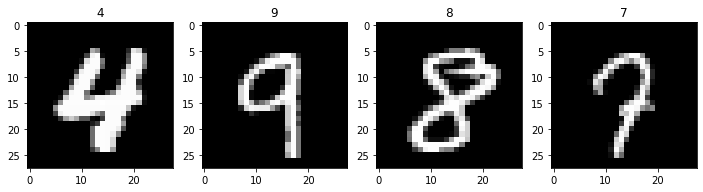

In [ ]:
#@title Loading the data
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

data_shape = (1, 28, 28)

# Plot a few examples
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
  im, label = mnist[random.randint(0, len(mnist))]
  axs[i].imshow(im.squeeze(), cmap='gray')
  axs[i].set_title(label)

In [ ]:
#@title A function to evaluate a trained model on the validation set

def mnist_score(model):
  correct = 0
  total = len(mnist_val)
  test_loader = DataLoader(mnist_val, batch_size=16, shuffle=True)

  with torch.no_grad():
    # Iterate through test set minibatchs
    for data, labels in tqdm(test_loader):
      data, labs = data.to(device), labels.to(device) # Move the data to GPU for faster execution.
      y = model(data) # Forward pass
      predictions = torch.argmax(y, dim=1) # The model has ten outputs, one for each digit. Here we take the index with the highest output
      correct += torch.sum((predictions == labs).float())
  
  return correct/total

In [ ]:
#@title Defining a small neural network - 'MiniMLP'
class MiniMLP(nn.Module):
  def __init__(self):
    super(MiniMLP, self).__init__()
    self.fc1 = nn.Linear(28*28, 128) # 28*28 inputs, 128 hidden units
    self.fc2 = nn.Linear(128, 10) # 10 outputs (for 10 digits)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x
    

In [ ]:
#@title Defining a small CNN - 'MiniCNN'
class MiniCNN(nn.Module):
  def __init__(self):
    super(MiniCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10) # 10 outputs (for 10 digits)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

Epoch 0


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 1


  0%|          | 0/938 [00:00<?, ?batch/s]

Scoring...


  0%|          | 0/625 [00:00<?, ?it/s]

Test accuracy: 89.35%


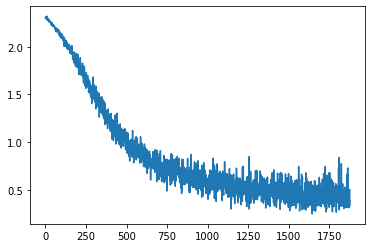

In [ ]:
# Data in dataloader
train_loader = DataLoader(mnist, batch_size=64, shuffle=True)

# Set up model, loss and optimizer
model = MiniMLP().to(device) # << Swap out for MiniCNN and compare
criterion = nn.CrossEntropyLoss() # Why not just use accuracy?
optimizer = torch.optim.SGD(model.parameters(),lr=0.01) # See also: torch.optim.AdamW and many others

# Track our losses
losses = []

# The training loop
for epoch in range(2):
  print(f'Epoch {epoch}')
  for data, target in tqdm(train_loader, unit='batch'):
    data, target = data.to(device), target.to(device) # When in doubt, .to(device)
    optimizer.zero_grad() # Reseat all gradient calculations
    output = model(data) # Get the model output
    loss = criterion(output, target) # Calculate the loss
    loss.backward() # 'Backpropagate' the error and calculate the gradients
    optimizer.step() # Update the parameters based on those gradients
    losses.append(loss.item()) # Store the loss for later plotting (optional)

# Evaluating the model on an unseen test set
print('Scoring...')
print(f'Test accuracy: {mnist_score(model) * 100:.2f}%')

# Plot the losses over time
plt.plot(losses)

Things to try:
- Experiment with changing batch size, network type, learning rate, optimiser type etc.
- See if you can modify one of the networks defined above. How does the MiniMLP do with only 32 neurons in the hidden layer? Can you shrink the MiniCNN to have even fewer parameters? 

Check out something like the [pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). It looks a little more complicated, but can you see the resemblance between their training loop and ours? Similar right! Uncomment the cell below to visualize the model they use (and compare to our little MiniCNN)

In [ ]:
#torchvision.models.resnet18()

# Section 2: Loss Functions

![gif captioned sorry for your loss](https://c.tenor.com/bQ-IsGnfWVkAAAAC/sorry-for-your-loss-my-condolences.gif)

## 2.1 Introduction
So NNs can learn some pretty complex functions, but we need a way to tell them what we want. For classification, we set up our loss such that if the network assigned a high predicted probability for the wrong label, the loss was high. In trying to minimise this loss, it 'learns' to output the correct labels as often as it can.

Not all tasks are classification tasks! Let's look at some examples of other kinds of losses:
- (R)MSE for continuous variables
- Regularization, a penalty applied to the parameters themselves for various reasons (discuss)
- Contrastive losses (eg. you may want a network to have similar outputs for different photos of the same face, but low similarity between the outputs for faces from different people.
- Perceptual loss (a term I often switch with 'content loss' in some contexts): using a fancy neural network to jusdge how much an image (or other output) "looks" like another image. Useful in cases where you care about overall appearance but don't mind if individual pixels are different.
- Style loss: Usually calculated using the early layers of a pretrained network to identify styles and textures, calculated in a way that focuses on these textures but NOT the large-scale structures that would be picked up by a perceptual loss
- Other custom penalties - maybe you want to minimise the saturation of a generated image, or how sharp and noisy the textures are...

Losses can be combined in different ways. For style transfer we try to minimise some combination of the content loss w.r.t. one input image and the style loss w.r.t. a second image. Many networks try to minimise some primary loss (related to classification perhaps) but have additional losses or regularization terms added to stabilise training, or to give some additional desired properties. And in something like reinforcement learning you may have a very complex loss/reward function based on what tasks an agent accomplished, how efficiently they were done, extra rewards to encourage exploration or discourage risk-taking and many more. 

It's quite crazy when you think about it! We used to program by telling the computer what to do. But now we 'program' by telling the computer what we want, and having it do the hard work figuring out how to achieve that. Andrej Karpathy called this 'Software 2.0' in this classic blog post: https://karpathy.medium.com/software-2-0-a64152b37c35

As a conrete example, in the next section we'll try combining two different loss functions with a quick style transfer demo.


## 2.2 Style Transfer

In Lesson 2 we talked about learning representations, and how the successive layers of a deep neural network are able to capture more and more concepts in a sort of hierarchical way. We can tap into these intermediate layers of a network and extract the outputs of a given layer when an image is fed into the network - these become the 'representations' we use when we want to compare the semantic (content) or stylistic (texture/color/style) components of an image.

For this demo we're not going to go in-depth on exactly how this works - the important bit is that we can combine these two different measures to achieve a specific artistic effect.

We're also going to depart from the standard practice of optimizing an image, and instead use something like an image 'pyramid' with a stack of tensors of different resolutions, via the [imstack library](https://johnowhitaker.github.io/imstack/)

In [ ]:
# @title Some useful functions

# Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch
class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        self.features = vggModel.features
        
        #desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        #making this model's parameters untrainble
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()  #outputs from the selected layers
        
        #for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) #apply the layer
            
            #if this layer is a desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)
                
                #check if we got all desired layers
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs


# The network we'll use for content and style loss
vgg = vgg16(pretrained=True)

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# A convenience function for going from a PIL image to a tensor:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0)

def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

# The gram matrix
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

In [ ]:
#@title download content and style images (feel free to try your own!)
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58517  100 58517    0     0   313k      0 --:--:-- --:--:-- --:--:--  315k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200k  100  200k    0     0  2388k      0 --:--:-- --:--:-- --:--:-- 2388k


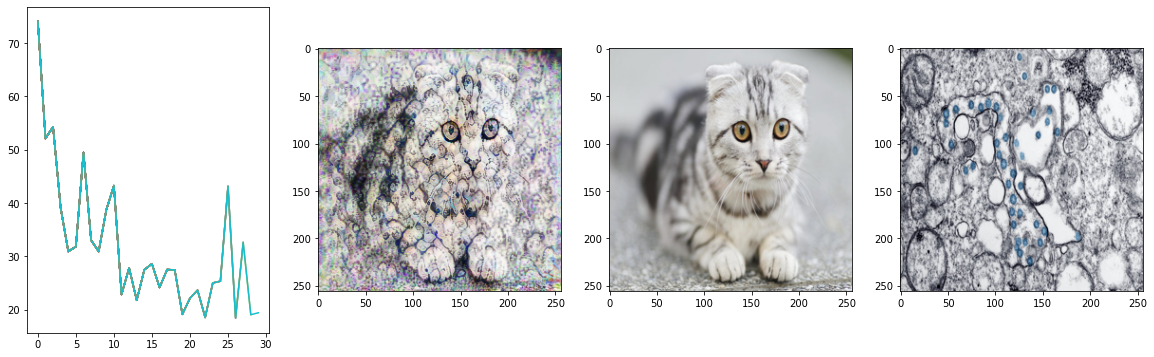

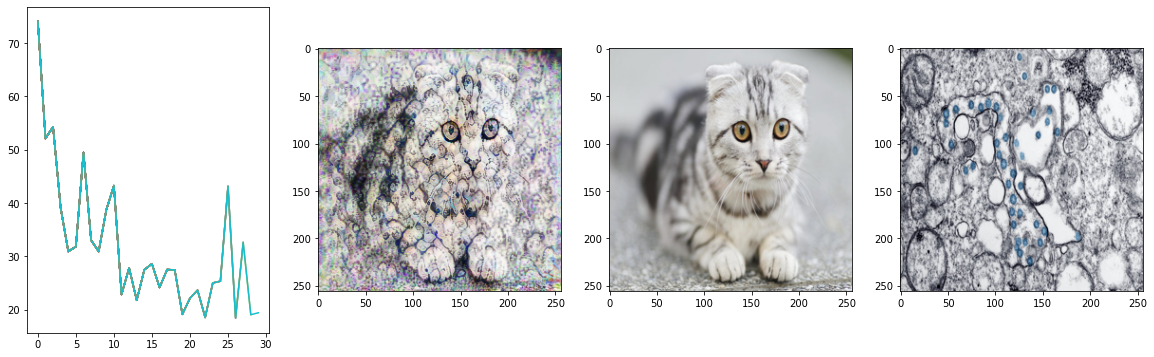

In [ ]:
#@title Style Transfer

size = 256 #@param
width, height = size, size

style_image_path = 'style.jpeg' #@param
style_image = Image.open(style_image_path).convert('RGB').resize((width, height))
content_image_path = 'cat.jpeg' #@param
content_image = Image.open(content_image_path).convert('RGB').resize((width, height))

content_layers = [19] #@param
contentExtractor = VGGFeatureExtractor(vgg,  content_layers).to(device)
content_im_tensor = pil_to_torch(content_image).to(device)
target_content_features = contentExtractor(content_im_tensor)

style_layers = [5, 7, 10, 12, 17] #@param
styleExtractor = VGGFeatureExtractor(vgg,style_layers).to(device)
style_im_tensor = pil_to_torch(style_image).to(device)
target_style_features = styleExtractor(style_im_tensor)

# We'll do a little data augmentation just for fun
tfms = transforms.Compose([
    transforms.RandomResizedCrop(size),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
])

out_size=size
base_size=8 #@param
n_layers=5 #@param
scale=3 #@param
ims = ImStack(out_size=size, init_image=content_image)
# ims = ImStack()

lr=0.05 #@param
optimizer = torch.optim.AdamW(ims.layers, lr=lr)

# Weights we'll give to the different losses
style_weight = 0.1 #@param
content_weight = 0.9 #@param

n_tfms = 4 #@param


# Display
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
p = display(fig,display_id=True)

# The training loop
losses = []  # keeping recods of loss
n_iter = 30 #@param
for i in range(n_iter): # 500 'epochs' of training
  optimizer.zero_grad()  # set gradients to 0
  im = ims()
  loss = 0
  for i in range(n_tfms):
    loss += style_weight * style_loss(tfms(im.clip(0, 1)), target_style_features)
    loss += content_weight * content_loss(tfms(im.clip(0, 1)), target_content_features)
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step)

  # Storing our loss for later viewing
  losses.append(loss.item())
  if i % 3 == 0:
    with torch.no_grad():
      axs[0].plot(losses, label='Loss:'+str(loss.item()))
      axs[1].imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
      axs[2].imshow(content_image)
      axs[3].imshow(style_image)
      p.update(fig)

ipd.clear_output()
ipd.clear_output()
p.update(fig)

Experiment with your own images. 

Stadard disclaimer: This is not the best style transfer implementation by any means - it's written as a demo to get the concept across quickly. 

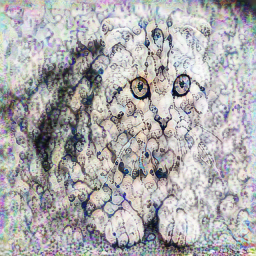

In [ ]:
# View (or save by uncommenting the rest of the line)
ims.to_pil()#.save('im.jpg')

Standalone version: https://colab.research.google.com/drive/1Zh3OxXE0OWqwzrAhvUBX2VtRBgz87ahQ?usp=sharing

More info in Lesson 2: https://colab.research.google.com/drive/1Rk8cXMdad9ASIVI6avPyp5bl0qmeOu6S?usp=sharing

## 2.3 CLIP & friends



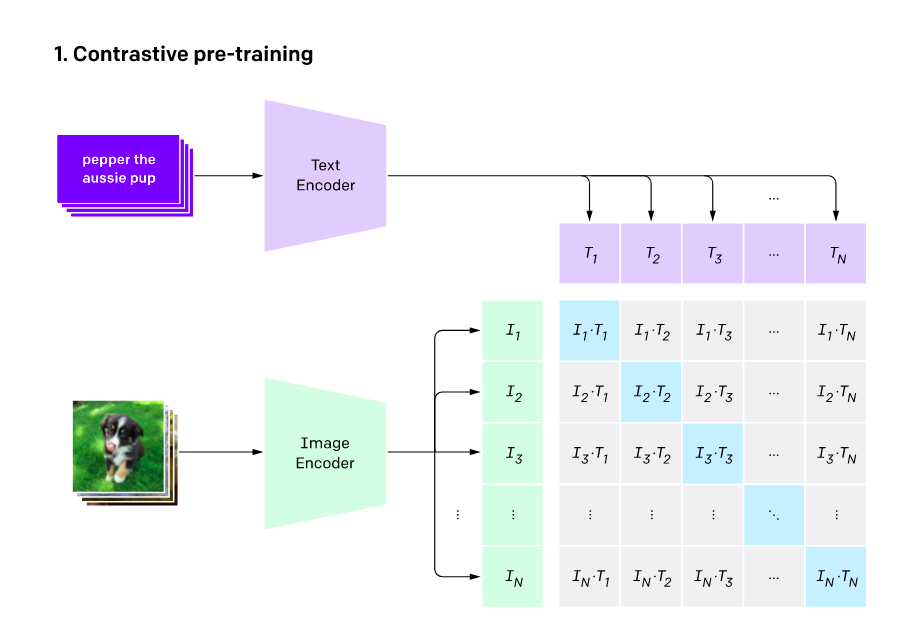

CLIP is an interesting model to examine in the context of loss functions. It is trained using a contrastive loss that has it trying to maximise the similarity between image-text pairs that match, while trying to minimise the similarity between images and text that are unrelated.

The output of the model is an 'embedding' - an encoded representation of the input (be it text or an image) that lives in some 512 dimensional space. We can compare these embeddings to see how related the model things two inputs are.

In [3]:
# Set up the CLIP model we'll be using
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
cut_size = perceptor.visual.input_resolution
cutn=64
cut_pow=1
make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow)

In [4]:
# Embed some text
text_embed = perceptor.encode_text(clip.tokenize("A dog").to(device)).float()
text_embed.shape

torch.Size([1, 512])

In [5]:
# Embed a random image
im = torch.rand(1, 3, 224, 224) # Does this work with different sizes?
image_embed = perceptor.encode_image(normalize(im).to(device)).float()
image_embed.shape

torch.Size([1, 512])

In [6]:
# See what make_cutouts does
normalize(make_cutouts(im)).shape

torch.Size([64, 3, 224, 224])

  0%|          | 0/100 [00:00<?, ?it/s]

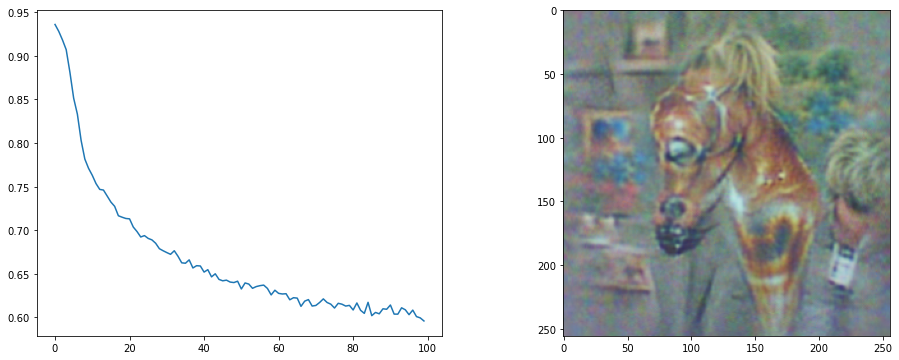

In [11]:
# We'll try to match this text
embed = perceptor.encode_text(clip.tokenize("An oil paintint horse").to(device)).float()
prompt = Prompt(embed, 1, float('-inf')).to(device)

# The ImStack
ims = ImStack()

# The optimizer
optimizer = optim.Adam(ims.layers, lr=5e-2, weight_decay=1e-4)

# Track out losses
losses = []

# The optimization loop
for i in tqdm(range(100)):

  # Zero grads
  optimizer.zero_grad()
  
  # get image
  im = ims()

  # encode with CLIP  
  iii = perceptor.encode_image(normalize(make_cutouts(im))).float()

  # Calculate loss  
  loss = prompt(iii)

  # Store
  losses.append(loss.item())

  # Step optim
  loss.backward()
  optimizer.step()

# Show loss plot and final result
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(losses) 
axs[1].imshow(ims.to_pil())

Phew, that's a big wall of code! Let's tweak the default imstack settings, add easy control for some parameters and wrap it up in a nicer interface to make it less scary:

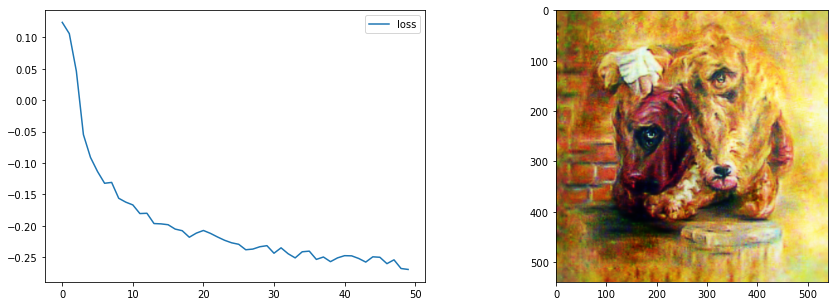

In [14]:
#@title Fancier interface

# A list of positive prompts
prompt_texts = ['A oil painting of a dog'] #@param
lr=0.25 #@param
weight_decay=1e-5 #@param
n_iter=50 #@param
out_size=540 #@param
base_size=8 #@param
n_layers=5 #@param
scale=3 #@param

# The prompts
p_prompts = []
for pr in prompt_texts:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  p_prompts.append(Prompt(embed, 1, float('-inf')).to(device)) # 1 is the weight

# Some negative prompts
n_prompts = []
for pr in ["Random noise", 'saturated rainbow RGB deep dream']:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  n_prompts.append(Prompt(embed, 0.5, float('-inf')).to(device)) # 0.5 is the weight

# The ImageStack - trying a different scale and n_layers
ims = ImStack(base_size=base_size, scale=scale, n_layers=n_layers, out_size=out_size, decay=0.4)

optimizer = optim.Adam(ims.layers, lr=lr, weight_decay=weight_decay)
losses = []

# Some fancier progress bar stuff
mb = master_bar(range(1))
mb.names=['loss']
mb.graph_fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # For custom display
mb.graph_ax = axs[0]
mb.img_ax = axs[1]
mb.graph_out = display(mb.graph_fig, display_id=True)

for p in mb:
  for i in progress_bar(range(n_iter), parent=mb):
    optimizer.zero_grad()

    im = ims()
    iii = perceptor.encode_image(normalize(make_cutouts(im))).float()
    
    l = 0
    for prompt in p_prompts:
      l += prompt(iii)
    for prompt in n_prompts:
      l -= prompt(iii)

    losses.append(float(l.detach().cpu()))
    l.backward() # Backprop
    optimizer.step() # Update

    # Show progress and loss plot
    mb.update_graph([[range(len(losses)), losses]])

    # View every 5 iterations
    if i % 5 == 0:
      img = ims.to_pil()
      mb.img_ax.imshow(img)
      mb.graph_out.update(mb.graph_fig)


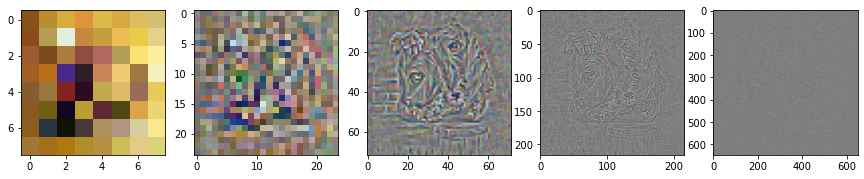

In [15]:
ims.plot_layers()

### CLOOB

![cloob diagram](https://ml-jku.github.io/cloob/assets/ArchTab.png)

A fairly recent improvement on CLIP is [CLOOB](https://github.com/ml-jku/cloob), which uses some modern hopfield networks (read 'magic') to increase the similarity of text and image embeds. In CLIP they aren't actually all that aligned - cloob improves average similarity from like 0.3 to 0.9 apparently, meaning we can do some very nifty tricks with it (see the diffusion lesson coming soon for CLOOB-conditioned latent diffusion).

It's interesting to compare CLOOB trained on the LAION dataset with OpenAI's CLIP and OpenCLIP. 

Here are two versions of the above demo as standalone notebooks:

CLOOB version: https://colab.research.google.com/drive/1PAPb2PiGHxnPwF2JaYKFnE063vXJPRfu?usp=sharing

CLIP version (standalone) with comparison to raw pixel optimization: https://colab.research.google.com/drive/10gSIlqRGom18kl8NZSytyWYciej8H46N?usp=sharing

Another easy-to-use CLIP implementation with some different pre-trained models available: https://github.com/mlfoundations/open_clip

A demo you can try in the browser using imstack + CLOOB along with a model to 'sketchify' an input: https://huggingface.co/spaces/johnowhitaker/waterface (blog post on the extra model: https://datasciencecastnet.home.blog/2022/03/29/sketchy-unet/)

# Section 3: Getting to grips with latent space

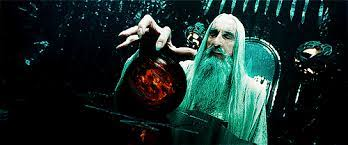

Optimising an image directly is inefficient.

ImStack is slightly better, but still not ideal.

There are networks trained to generate realistic outputs from realtively low-dimensional inputs, and some (eg VAEs) encode to this latent space and back out. We can optimise a vector in this latent space to get some desired effect at the output. This is the key idea behind some of the early new CLIP-guided art techniques like BigSLEEP, VQGAN+CLIP etc.

To get a bit of a handle on this whoe latent space business, we'll play around in the latent space of a GAN I trained on a quirky dataset of colourful orbs, which were themselves generated by another type of model.

In [ ]:
#@title Some additional setup (requires restarting the runtime)
!git clone https://github.com/huggingface/community-events/ &>> install.log
!pip install datasets &>> install.log# Can remove wandb and accelerate I think
!apt install git-lfs &>> install.log
!cd community-events/;pip install -e . &>> install.log
!export PYTHONPATH="${PYTHONPATH}:/content/community-events/"

## 3.1 Loading a GAN

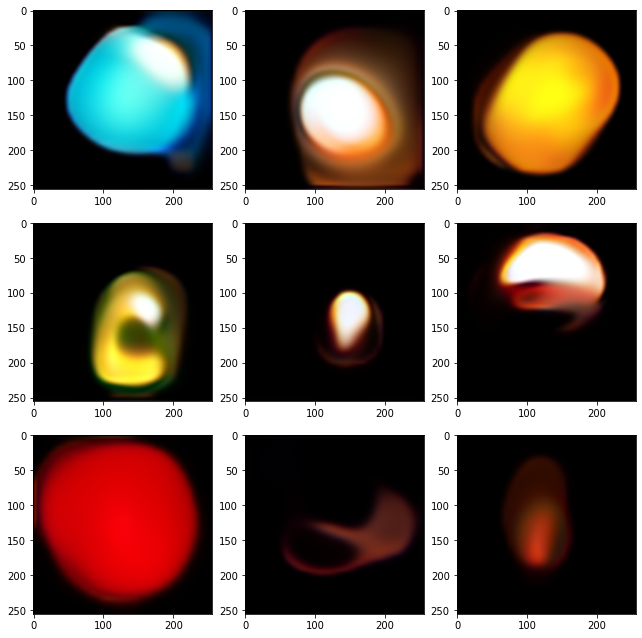

In [ ]:
# orbgan demo
import torch, torchvision
import sys
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Sometimes you want to import code from a python file elsewhere on a machine:
sys.path.append('/content/community-events/huggan/pytorch/lightweight_gan')

# Ignore the warnings
from lightweight_gan import LightweightGAN

# Load the model (gan.G is the generator)
gan = LightweightGAN.from_pretrained('johnowhitaker/lwg_colorbs').cuda()

# View some examples
n_rows = 3
ims = gan.G(torch.randn(n_rows**2, 256).cuda()).clamp_(0., 1.)
fig, axs = plt.subplots(n_rows, n_rows, figsize=(9, 9))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(ims[i].permute(1, 2, 0).detach().cpu().numpy())

clear_output() # Hide the download bars and deprecation warnings
plt.tight_layout()

## 3.2 Moving in latent space

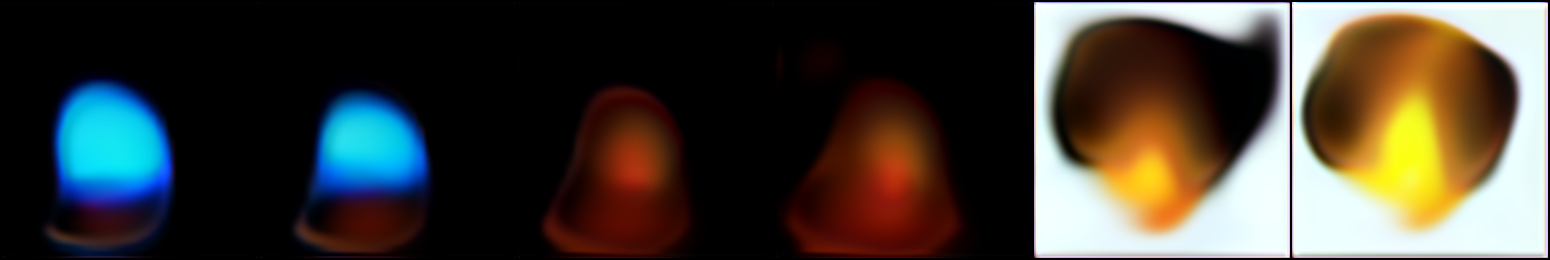

In [ ]:
# Pick two random points:
start, end = torch.randn(2, 256).cuda()

# Generate some intermediate points
latents = []
for i in range(6):
  latents.append(torch.lerp(start, end, weight=i/6)) # linear interpolation 

# Generate outputs from these latents and show
ims = gan.G(torch.stack(latents)).clamp_(0., 1.)
Image.fromarray((torchvision.utils.make_grid(ims, nrow=6).permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8))

In [ ]:
#@title Render a video of this kind of interpolation to latent_walk.mp4
from tqdm.notebook import tqdm
!mkdir -p steps
!rm steps/*.jpg

n_points = 6
n_steps = 300
latents = torch.randn(n_points, 256).cuda()

for i in tqdm(range(n_steps)):
  p1 = max(0, int(n_points*i/n_steps))
  p2 = min(n_points, int(n_points*i/n_steps)+1)%n_points # so it wraps back to 0
  frac = (i-(p1*(n_steps/n_points))) / (n_steps/n_points)
  l = latents[p1]*(1-frac) + latents[p2]*frac
  im = gan.G(l.unsqueeze(0)).clamp_(0., 1.)
  Image.fromarray((im[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8)).save(f'steps/{i:04}.jpg')

!ffmpeg -y -v 0 -i steps/%04d.jpg -c:v libx264 -r 12 -pix_fmt yuv420p latent_walk.mp4

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
#@title Display the video
from IPython.display import display, HTML 
from base64 import b64encode

def display_video(path):  
    mp4 = open(path,'rb').read()   
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(
      HTML(
      """
          <video width=400 controls>
                <source src="%s" type="video/mp4">
          </video>
      """ % data_url
           )   
    )

display_video('latent_walk.mp4')

## Optimising points in latent space towards some desirable output

0 0.3042158782482147
5 0.22773867845535278
10 0.13136900961399078
15 0.10125188529491425


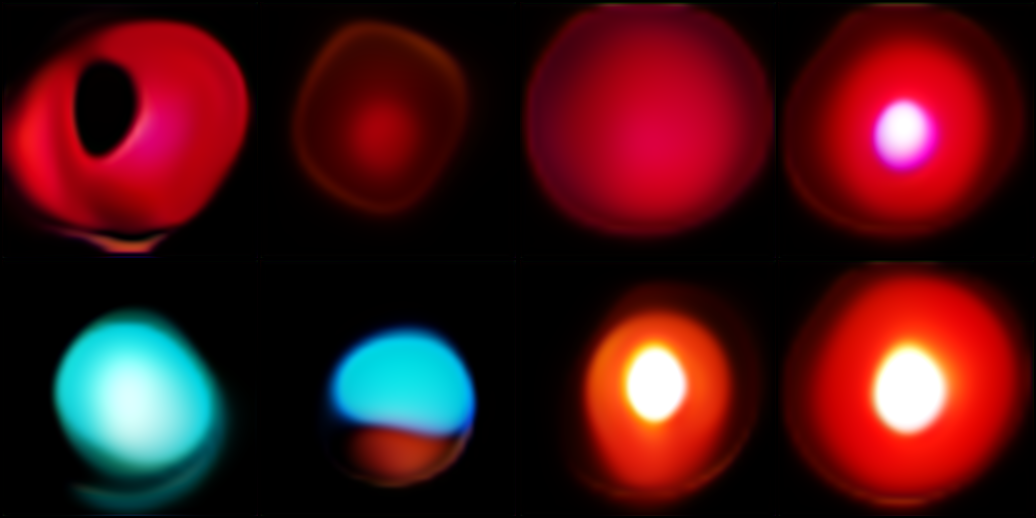

In [ ]:
target_color = torch.tensor([0.7, 0.3, 0.2]).cuda() # Dark orange
n_rows = 2

latents = torch.randn(n_rows**2, 256).cuda()
start_latents = latents.clone()
latents.requires_grad=True

optim = torch.optim.AdamW([latents], lr=0.2)

for i in range(20):
  optim.zero_grad() # Zero the gradients
  ims = gan.G(latents).clamp_(0., 1.) # Generate images from our latents

  # Loss calculation has two parts:

  # Mean color in the center should match target_color
  mean_colors = ims[:,:,50:-50,50:-50].mean(dim=-1).mean(dim=-1)
  loss = torch.abs(mean_colors - target_color).mean()
  
  # We want ones that are dark around the edges:
  loss += 0.5 * (torch.mean(ims[:,:,:20,:20]) + torch.mean(ims[:,:,:20,-20:]) + torch.mean(ims[:,:,-20:,:20]) + torch.mean(ims[:,:,-20:,-20:]))

  # We can just print out losses if we're lazy
  if i%5 ==0:print(i, loss.item())
  loss.backward()
  optim.step()

start_ims = torchvision.utils.make_grid(gan.G(start_latents).clamp_(0., 1.), nrow=int(n_rows)).permute(1, 2, 0).detach().cpu()
end_ims = torchvision.utils.make_grid(gan.G(latents).clamp_(0., 1.), nrow=int(n_rows)).permute(1, 2, 0).detach().cpu()
Image.fromarray((torch.cat([start_ims, end_ims], dim=1).numpy()*255).astype(np.uint8)) # start | end

A fun exercise would be to replace the colour loss above with a loss based on CLIP, and optimising towards a description like 'a green orb' or, more interesting, something like 'a face'. Who knows what this latent space contains! (probably mostly orbs)

We can do this for each pixel in a target image and draw some pretty cool things!

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

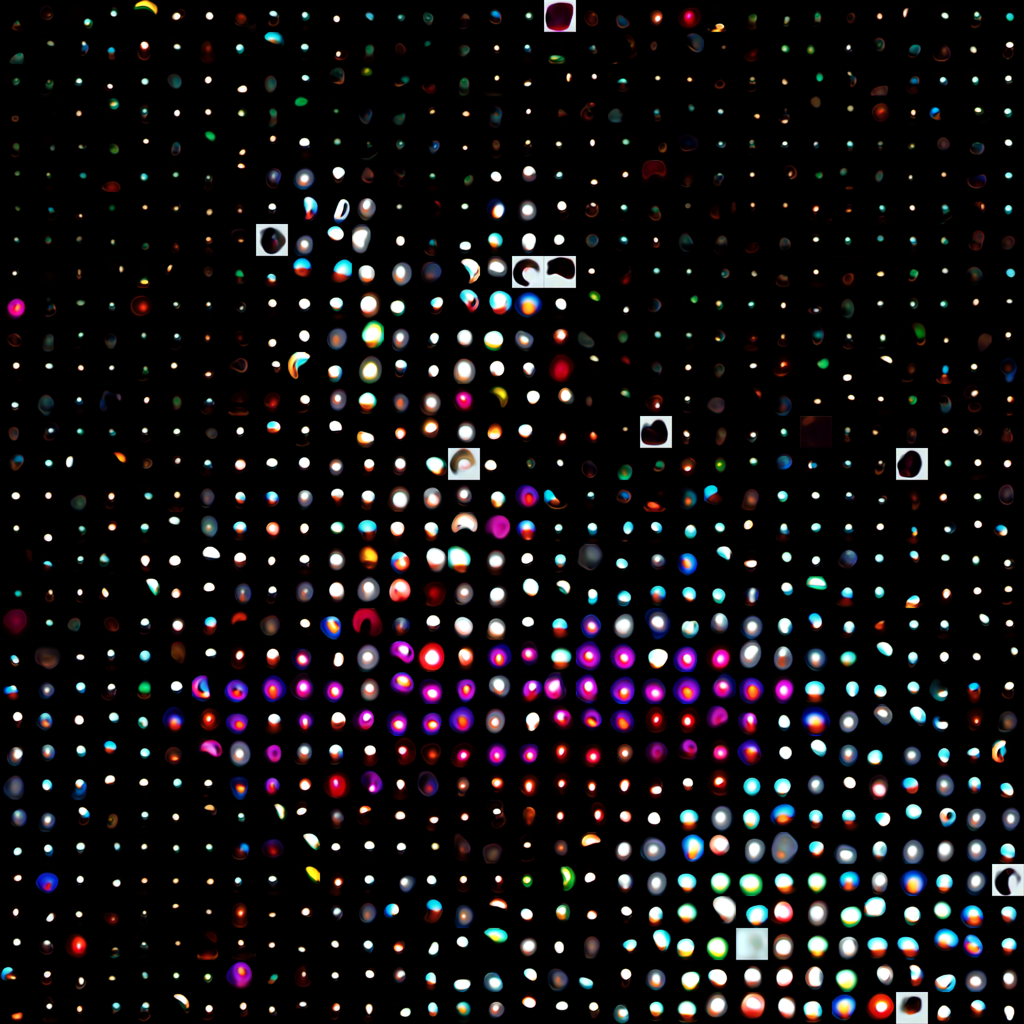

In [ ]:
#@title Optimising a bunch of latents to produce an output image montage
def ls_from_image(fn, w, h, batch_size=16, n_iter=50, brightness=0.8):
  all_latents = torch.zeros(w*h, 256)
  target_image = Image.open(fn).resize((w, h)).convert('RGB')
  target_colors = torch.tensor(np.array(target_image)/255).permute(2, 0, 1).reshape(3, w*h).cuda()
  target_colors *= brightness
  losses = []
  for i in tqdm(range(0, w*h, batch_size)):
    start, end = i, min(i+batch_size, w*h)
    latents = torch.randn(end-start, 256).cuda()
    latents.requires_grad = True
    target_color = target_colors[:,start:end].T
    optim = torch.optim.AdamW([latents], lr=5e-2)
    for i in range(n_iter):
      optim.zero_grad()
      ims = gan.G(latents).clamp_(0., 1.)
      # Average color in center square loss:
      mean_colors = ims[:,:,50:-50,50:-50].mean(dim=-1).mean(dim=-1)
      loss = torch.abs(mean_colors - target_color).mean()
      # Black outline loss (higher in this case since I want to enforce it more)
      loss += 2 * (torch.mean(ims[:,:,:20,:20]) + torch.mean(ims[:,:,:20,-20:]) + torch.mean(ims[:,:,-20:,:20]) + torch.mean(ims[:,:,-20:,-20:]))
      loss.backward()
      optim.step()
      losses.append(loss.item())
    all_latents[start:end] = latents.clone()
  return all_latents

def image_from_latents(latents, w, h, tile_size=(256, 256), batch_size=16):
  output = Image.new('RGB', (w*tile_size[0], h*tile_size[1]))
  for i in tqdm(range(0, w*h, batch_size)):
    start, end = i, min(i+batch_size, w*h)
    ims = gan.G(latents[start:end].cuda()).clamp_(0., 1.)
    for j, im in enumerate(ims):
      pos = i + j
      x = pos%w * tile_size[0]
      y = (pos//w) * tile_size[1]
      im_array = np.array(im.detach().cpu().permute(1, 2, 0)*255).astype(np.uint8)
      pil_im = Image.fromarray(im_array).resize(tile_size)
      output.paste(pil_im, (x, y))
  return output

w, h = 32, 32
ls = ls_from_image('/content/butterfly.png', w, h, batch_size=16) # from https://www.pexels.com/photo/blue-brown-white-black-66877/
o = image_from_latents(ls, w, h)
o.save('output.png')
o.resize((w*32, h*32)) # Show a smaller version